In [2]:
import torch
import pickle
import os

from tqdm.notebook import tqdm

ADAPTERS = [{
        "dir" : "./open_llama_3b_v2_sft/",
        "moniker" : "pre"
    }, {
        "dir" : "./open_llama_3b_v2_sft_full/",
        "moniker" : "sft"
    }, {
        "dir" : "./open_llama_3b_v2_sft_plus_dpo/",
        "moniker" : "dpo",
    }, {
        "dir" : "./open_llama_3b_v2_sft_plus_dpo_r4",
        "moniker" : "dpo_r4"
}]

torch.manual_seed(42)

## Generate Evaluation metrics
---

In [ ]:
from typing import Tuple
from peft import AutoPeftModelForCausalLM
from transformers import (
    BitsAndBytesConfig,
    pipeline,
    AutoTokenizer
)
from datasets import load_dataset

from reward import get_reward

In [2]:
dataset_name = "samlhuillier/sql-create-context-spider-intersect"
response_template = "\n-- Answer:\n"
def format_prompt(example) -> Tuple[str, str]:
    return f"{example['context']} \n-- Question: {example['question']}{response_template}", example['answer']

In [3]:
dataset = load_dataset(dataset_name, split="validation").map(lambda example: {"query" : format_prompt(example)[0]})

In [4]:
dataset[0]

{'answer': 'SELECT count(*) FROM singer',
 'db_id': 'concert_singer',
 'context': 'CREATE TABLE singer (Id VARCHAR)',
 'question': 'How many singers do we have?',
 'query': 'CREATE TABLE singer (Id VARCHAR) \n-- Question: How many singers do we have?\n-- Answer:\n'}

In [5]:
# Model from Hugging Face hub
base_model = "openlm-research/open_llama_3b_v2"

In [6]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
def load_model(adapter_dir):
    # Load model
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=False,
    )
    
    dpo_model = AutoPeftModelForCausalLM.from_pretrained(
        adapter_dir,
        quantization_config=quant_config,
        trust_remote_code=True,
        is_trainable=True,
    )
    
    dpo_model.config.use_cache = False
    dpo_model.config.pretraining_tp = 1
    
    return dpo_model.merge_and_unload().eval()

In [8]:
def get_logger(quiet=True, outfile="eval_out.txt"):
    def log(txt):
        with open(outfile, "a", encoding="utf-8") as f:
            f.write(f"{txt}\n")
        if not quiet:
            print(txt)
    return log

In [9]:
def get_eval_rewards(model, quiet=True, sample_size=-1, logfile="eval_out.txt"):
    p = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=120)
    
    rewards = []
    if sample_size >= 0:
        inds = torch.randperm(len(dataset))[:sample_size]
        ds = dataset.select(inds)
    else:
        ds = dataset

    log = get_logger(quiet, logfile)
    for row in tqdm(ds):
        out = p(row["query"])
        response = out[0]["generated_text"]
        
        # remove our query, split by newlines
        response_lines = response.replace(row["query"], "").split("\n")
        model_submission = response_lines[0]
        rew = get_reward(row["db_id"], model_submission, row["answer"])
        rewards.append(rew)
        
        log(row["query"])
        log(model_submission)
        log("-------------------------------------------------")
        log(f"-- Got reward of {rew} against solution:")
        log(row['answer'])
        log("-------------------------------------------------")
    
    return rewards

In [10]:

if not os.path.isdir("eval_results/"):
    os.mkdir("eval_results/")

for adapter in ADAPTERS:
    moniker = adapter['moniker']
    print("Evaluating", moniker, "...")
    rewards = get_eval_rewards(load_model(adapter["dir"]), 
                                quiet=True, sample_size=50, 
                                logfile=f"eval_results/{moniker}_eval_out.txt")

    with open(f"eval_results/{adapter['moniker']}_eval_returns.pkl", "wb") as f:
        pickle.dump(rewards, f)

Evaluating pre ...


/home/ubuntu/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:229: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Evaluating sft ...


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating dpo ...


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating dpo_r4 ...


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
def load_reward(adapter) -> list:
    with open(f"eval_results/{adapter['moniker']}_eval_returns.pkl", "rb") as f:
        return pickle.load(f)

In [12]:
for adapter in ADAPTERS:
    rews = torch.tensor(load_reward(adapter))
    print(f"Adapter {adapter['moniker']} got reward", rews.mean(), "+-", rews.std())

Adapter pre got reward tensor(0.5752, dtype=torch.float64) +- tensor(0.2469, dtype=torch.float64)
Adapter sft got reward tensor(1.3521, dtype=torch.float64) +- tensor(0.4724, dtype=torch.float64)
Adapter dpo got reward tensor(1.4493, dtype=torch.float64) +- tensor(0.4367, dtype=torch.float64)
Adapter dpo_r4 got reward tensor(1.4397, dtype=torch.float64) +- tensor(0.4094, dtype=torch.float64)


## Post-generation
---
Run from here if you have the eval metrics pregenerated and available at `eval_results/`

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [132]:
def load_eval_outs(moniker: str, delim = "---") -> pd.DataFrame:
    with open(f"eval_results/{moniker}_eval_out.txt", "r") as f:
        lines = f.readlines()

    in_solution = False
    out_entries = [ ]
    resp = ""
    sol = ""
    for line in lines:
        is_delim = delim in line

        if is_delim:
            in_solution = not in_solution
            if sol != "":
                sol_query = sol.split("\n")[1]
                rew = float(sol.split("\n")[0]
                               .replace("-- Got reward of" , "")
                               .replace("against solution:", "")
                               .strip() )
                prompt = "\n".join(resp.strip().split("\n")[:-1]).strip()
                response = resp.strip().split("\n")[-1].strip()
                out_entries.append({
                    "prompt" : prompt,
                    "response" : response,
                    "solution" : sol_query,
                    "reward" : rew
                })
                resp = ""
                sol = ""
        else:
            if in_solution:
                sol += line
            else:
                resp += line
    
    return pd.DataFrame(out_entries)

In [133]:
returns = {
    adapter['moniker'] : load_eval_outs(adapter['moniker'])
    for adapter in ADAPTERS
}

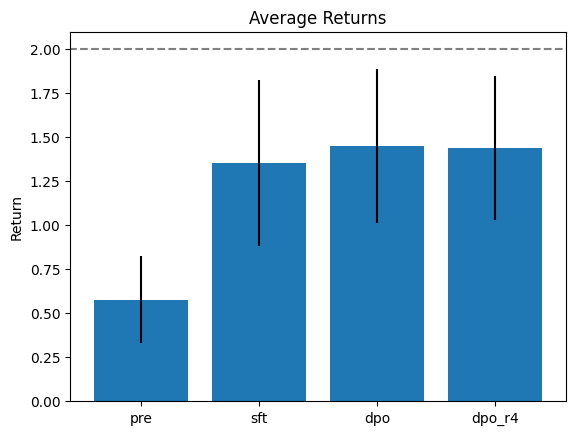

In [139]:
plt.bar(x=list(returns.keys()), 
        height=list(map(lambda df: df['reward'].mean(), returns.values())), 
        yerr=list(map(lambda df: df['reward'].std(), returns.values()))
)
plt.hlines([2.0],[-0.7],[3.7], linestyles="--", color="gray")
plt.xlim(-0.6, (len(returns.keys()) - 1) + .6)
plt.title("Average Returns")
plt.ylabel("Return")
plt.show()